### Import packages:

In [1]:
# import dva_sdhdf_combine
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from ipywidgets import interact

#### Change the directory to where the files are located" ####
day ='25'
directory = '../DVA/Data_Files/DVA_Day_Surveys/'

### Change the scan details to your current scan
df = 0.5        
dt = 6.9444431574083865e-06

#TODO: actually do the scan properties definition in the beginning
##############################################################

### Read in the file listing azimuth scan start and stop times:

In [2]:
scan_id = []    # The scan id number
scan_start = []  # Start time of the scan (UTC)
scan_stop = []   # Stop time of the scan (UTC)

# Read in the data and store it in arrays:
with open(directory+'DVAsurvey_phase1_day0'+day+'.txt') as fp:
    for line in fp:       
        scan_id.append(int(line.split()[0]))
        scan_start.append(line.split()[1]+'T'+line.split()[2][0:12])
        scan_stop.append(line.split()[3]+'T'+line.split()[4][0:12])
        
# Print out the scan numbers with their start and stop times:
for i in range(0,len(scan_id)):
    print(f"{scan_id[i]:04}",scan_start[i],scan_stop[i])

# Convert start and stop times to Modified Julian Day (MJD).
# This is needed for plotting and for selecting out data collected
# between particular times:
scan_start_mjd = Time(scan_start, format='isot',scale='utc').mjd
scan_stop_mjd  = Time(scan_stop,  format='isot',scale='utc').mjd


1052 2022-07-04T03:57:53.110 2022-07-04T04:15:55.184
2565 2022-07-04T04:20:37.406 2022-07-04T04:38:39.310
2566 2022-07-04T04:40:22.266 2022-07-04T04:58:24.003
1271 2022-07-04T05:03:42.716 2022-07-04T05:21:44.818
1272 2022-07-04T05:23:27.291 2022-07-04T05:41:29.292
2857 2022-07-04T05:48:35.269 2022-07-04T06:06:37.317
0124 2022-07-04T06:11:19.190 2022-07-04T06:29:21.101
1637 2022-07-04T06:34:03.920 2022-07-04T06:52:06.005
0342 2022-07-04T06:57:23.897 2022-07-04T07:15:25.930
1927 2022-07-04T07:21:55.804 2022-07-04T07:39:58.034
1928 2022-07-04T07:42:16.530 2022-07-04T08:00:18.319
2001 2022-07-04T08:03:48.814 2022-07-04T08:21:51.062
2002 2022-07-04T08:24:09.373 2022-07-04T08:42:11.545
2075 2022-07-04T08:45:41.821 2022-07-04T09:03:44.188
2148 2022-07-04T09:07:50.625 2022-07-04T09:25:52.832
2149 2022-07-04T09:27:35.229 2022-07-04T09:45:37.044
2150 2022-07-04T09:47:56.026 2022-07-04T10:05:57.828
2151 2022-07-04T10:07:40.752 2022-07-04T10:25:42.662
2152 2022-07-04T10:27:25.410 2022-07-04T10:45:

## Read in scan files and stich them together:

In [9]:
t_set = []
az_set = []
dec_set = []
ra_set = []
el_set = []
noise_set = []
trim_flag = []

scan0 = f"{scan_id[0]:04}"

# Use one of the scans to get the list of frequencies:
file = h5py.File(directory+'dva_survey_raw_scan_'+scan0+'.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][::12]/1e6

# Create empty arrays for the power data:
RR_set_raw = np.empty([0,len(freq)])
LL_set_raw = np.empty([0,len(freq)])
reRL_set_raw = np.empty([0,len(freq)])
imRL_set_raw = np.empty([0,len(freq)])

# Loop through all the scans in the "scan_num" list:
for i in scan_id:
    print(i)
    # select the file:
    file = h5py.File(directory+'dva_survey_raw_scan_'+f"{i:04}"+'.h5','r')
    print(file)
    
    # access the correct location in the file structure:
    dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
    # Add the position and time data to the corresponding arrays:
    # dec_set = np.concatenate([dec_set,dataset['metadata']['declination']])
    # ra_set = np.concatenate([ra_set,dataset['metadata']['right_ascension']])
    # el_set = np.concatenate([el_set,dataset['metadata']['elevation']])
    # az_set = np.concatenate([az_set,dataset['metadata']['azimuth']])
    t_set = np.concatenate([t_set,dataset['metadata']['utc']])
    noise_set = np.concatenate([noise_set,dataset['metadata']['noise_state']]) #This is a "mask" for noise regions 1 = noise 0=all good
    # trim_flag = np.concatenate([trim_flag,dataset['metadata']['trim_scan_flag']])
    
    # Add the spectrometer power data to the corresponding arrays:
    freq_channel_increment = 12 #TODO: I'll have to change this to 1 once I am sure I'm reading the data correctly
    RR_set_raw = np.concatenate([RR_set_raw,dataset['data'][:,0,::freq_channel_increment]],axis=0)
    LL_set_raw = np.concatenate([LL_set_raw,dataset['data'][:,1,::freq_channel_increment]],axis=0)
    reRL_set_raw = np.concatenate([reRL_set_raw,dataset['data'][:,2,::freq_channel_increment]],axis=0)
    imRL_set_raw = np.concatenate([imRL_set_raw,dataset['data'][:,3,::freq_channel_increment]],axis=0)
    
t_set_plt = Time(t_set, format='isot',scale='utc').mjd

1052
<HDF5 file "dva_survey_raw_scan_1052.h5" (mode r)>
2565
<HDF5 file "dva_survey_raw_scan_2565.h5" (mode r)>
2566
<HDF5 file "dva_survey_raw_scan_2566.h5" (mode r)>
1271
<HDF5 file "dva_survey_raw_scan_1271.h5" (mode r)>
1272
<HDF5 file "dva_survey_raw_scan_1272.h5" (mode r)>
2857
<HDF5 file "dva_survey_raw_scan_2857.h5" (mode r)>
124
<HDF5 file "dva_survey_raw_scan_0124.h5" (mode r)>
1637
<HDF5 file "dva_survey_raw_scan_1637.h5" (mode r)>
342
<HDF5 file "dva_survey_raw_scan_0342.h5" (mode r)>
1927
<HDF5 file "dva_survey_raw_scan_1927.h5" (mode r)>
1928
<HDF5 file "dva_survey_raw_scan_1928.h5" (mode r)>
2001
<HDF5 file "dva_survey_raw_scan_2001.h5" (mode r)>
2002
<HDF5 file "dva_survey_raw_scan_2002.h5" (mode r)>
2075
<HDF5 file "dva_survey_raw_scan_2075.h5" (mode r)>
2148
<HDF5 file "dva_survey_raw_scan_2148.h5" (mode r)>
2149
<HDF5 file "dva_survey_raw_scan_2149.h5" (mode r)>
2150
<HDF5 file "dva_survey_raw_scan_2150.h5" (mode r)>
2151
<HDF5 file "dva_survey_raw_scan_2151.h5" (mod

### Import Leo's functions for RFI Excision

# NEW RFI_Excision functions (WORK IN PROGRESS)

1052
<HDF5 file "dva_survey_raw_scan_1052.h5" (mode r)>
2565
<HDF5 file "dva_survey_raw_scan_2565.h5" (mode r)>
2566
<HDF5 file "dva_survey_raw_scan_2566.h5" (mode r)>
1271
<HDF5 file "dva_survey_raw_scan_1271.h5" (mode r)>
1272
<HDF5 file "dva_survey_raw_scan_1272.h5" (mode r)>
2857
<HDF5 file "dva_survey_raw_scan_2857.h5" (mode r)>
124
<HDF5 file "dva_survey_raw_scan_0124.h5" (mode r)>
1637
<HDF5 file "dva_survey_raw_scan_1637.h5" (mode r)>
342
<HDF5 file "dva_survey_raw_scan_0342.h5" (mode r)>
1927
<HDF5 file "dva_survey_raw_scan_1927.h5" (mode r)>
1928
<HDF5 file "dva_survey_raw_scan_1928.h5" (mode r)>
2001
<HDF5 file "dva_survey_raw_scan_2001.h5" (mode r)>
2002
<HDF5 file "dva_survey_raw_scan_2002.h5" (mode r)>
2075
<HDF5 file "dva_survey_raw_scan_2075.h5" (mode r)>
2148
<HDF5 file "dva_survey_raw_scan_2148.h5" (mode r)>
2149
<HDF5 file "dva_survey_raw_scan_2149.h5" (mode r)>
2150
<HDF5 file "dva_survey_raw_scan_2150.h5" (mode r)>
2151
<HDF5 file "dva_survey_raw_scan_2151.h5" (mod

### Read in the times when the noise source was turned on, and mask this out in the power data:

In [10]:
t_noise1 = []
t_noise2 = []

with open(directory+'noise_mini_survey_part1.txt') as fp:
    for line in fp:       
        t_noise1.append(line.split()[0]+'T'+line.split()[1][0:12])
        t_noise2.append(line.split()[2]+'T'+line.split()[3][0:12])

t_noise1_plt = Time(t_noise1, format='isot',scale='utc').mjd
t_noise2_plt = Time(t_noise2, format='isot',scale='utc').mjd

# Buffer time (in seconds) around data points where noise source
# is being turned on or off:
t_buff = 1./(3600.*24.)

# Make copies of the arrays in which noise will be masked out:
RR_set = RR_set_raw.copy()
LL_set = LL_set_raw.copy()
reRL_set = reRL_set_raw.copy()
imRL_set = imRL_set_raw.copy()

print(len(LL_set))

# #Extract masks TODO: Currenct my Get_RFI_Excision_Mask only works for a single frequency
# time_steps = 30
# threshold = 4
# RR_mask = Get_RFI_Excision_Mask(t_plt, RR_set, time_steps, threshold)
# LL_mask = Get_RFI_Excision_Mask(t_plt, LL_set, time_steps, threshold)
# reRL_mask = Get_RFI_Excision_Mask(t_plt, reRL_set, time_steps, threshold)
# imRL_mask = Get_RFI_Excision_Mask(t_plt, imRL_set, time_steps, threshold)

# Loop through times when noise source was turned on and replace
# data values with NaN at those times:
for i in range(0,len(t_noise1)):
    wnoise_sub_rem = np.where( (t_plt >= t_noise1_plt[i]-t_buff) & (t_plt <= t_noise2_plt[i]+t_buff) )[0]
    RR_set[wnoise_sub_rem,:] = np.nan
    LL_set[wnoise_sub_rem,:] = np.nan
    reRL_set[wnoise_sub_rem,:] = np.nan
    imRL_set[wnoise_sub_rem,:] = np.nan

FileNotFoundError: [Errno 2] No such file or directory: '../DVA/Data_Files/DVA_Day_Surveys/noise_mini_survey_part1.txt'

In [ ]:
#TODO: Maybe I could create an interactive plot that if I tick a box I could flip to a power vs frequency plot or power vs time plot
#I should have a knob for changing frequency and time
#I could also introduce a vertical line to show which slice I'm currently at to help navigating through the data
df = freq[1]-freq[0]

def DVA_Waterfall_View(scan_id, show_all_scans):
    #TODO: Add another DVA_Waterfall interactive_function such that I can change between LL_Set, RR_set, etc...
    power_min = 70
    power_max = 78
    if not show_all_scans:
        w = np.where(np.array(scan_num) == scan_id)[0][0]
        t1_plt = scan_start_mjd[w]
        t2_plt = scan_stop_mjd[w]
        ######################################
        wplot = np.where( (t_plt <= t2_plt) & (t_plt >= t1_plt) )

        time_plot = t_plt[wplot]

        fig,axs = plt.subplots(1,1,figsize=(15,10)) 
        fs = 16

        im = axs.imshow(10.*np.log10(LL_set[wplot].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
                    extent=[time_plot[0],time_plot[-1],freq[0],freq[-1]])

        divider = make_axes_locatable(axs)
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.ax.tick_params(labelsize=fs) 
        cbar.set_label('Power (dB)', fontsize=fs)

        axs.set_xlim(time_plot[0],time_plot[-1])
        axs.set_ylim(freq[0],freq[-1])
        axs.tick_params(axis='both', labelsize=fs)
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs.set_xlabel('Time (UTC)',fontsize=fs)        
        axs.set_ylabel('Frequency (MHz)',fontsize=fs)
    else:
        fig,axs = plt.subplots(1,1,figsize=(15,10)) 
        fs = 16

        im = axs.imshow(10.*np.log10(LL_set.T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
                    extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])

        divider = make_axes_locatable(axs)
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.ax.tick_params(labelsize=fs) 
        cbar.set_label('Power (dB)', fontsize=fs)

        axs.set_xlim(t_plt[0],t_plt[-1])
        axs.set_ylim(freq[0],freq[-1])
        axs.tick_params(axis='both', labelsize=fs)
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs.set_xlabel('Time (UTC)',fontsize=fs)        
        axs.set_ylabel('Frequency (MHz)',fontsize=fs)

def DVA_Cross_Sections(scan_id, freq_chosen, time_idx, freq_cross_section):
    freq_measured = np.where(abs(freq-freq_chosen)<df)[0][0]
    
    w = np.where(np.array(scan_num) == scan_id)[0][0]
    t1 = scan_start[w]
    t2 = scan_stop[w]
    t1_plt = scan_start_mjd[w]
    t2_plt = scan_stop_mjd[w]
    
    wplot = np.where((t_plt>=t1_plt) & (t_plt<=t2_plt))
    
    polarized_set = Get_Polarized_Set(reRL_set, imRL_set, freq_measured)
    time_steps = 30
    threshold = 4
    polarized_mask = Get_RFI_Excision_Mask(t_plt[wplot], polarized_set[wplot], time_steps, threshold)
    LL_set_with_polarized_mask = Apply_RFI_Excision_Mask(polarized_mask, LL_set[wplot])
    
    fs = 12
    fig, axs = plt.subplots(1,1,figsize=(12,6))
    axs.scatter(ra_set_deg[wplot], dec_set[wplot],s=2,c=10.*np.log10(LL_set[wplot,freq_measured]),
                cmap='viridis',vmin=70.5, vmax=71.5)
    axs.set_xlabel('RA (deg.)',fontsize=fs)
    axs.set_ylabel('dec (deg.)',fontsize=fs)
    axs.tick_params(axis="x", labelsize=fs)
    axs.tick_params(axis="y", labelsize=fs)
    axs.set_xlim(360,0)
    axs.set_ylim(0,90)
    axs.set(aspect='equal')
    axs.grid()
    
    
    fig,axs1 = plt.subplots(1,1,figsize=(16,6))  
    # TODO: use the log of LL_set_clean

    if(freq_cross_section):
        time_chosen = int(time_idx/len(LL_set_with_polarized_mask)) #NOTE: I have no idea what 100 actually means
        axs1.plot(freq, LL_set_with_polarized_mask[time_chosen,:], label = 'LL_set with polarized mask')   #I need to plot freq vs power
        axs1.vlines(freq_chosen, 0 , 100e9, color = 'red')
        axs1.set_ylim(0, np.max(LL_set_with_polarized_mask[time_chosen,:]))
        axs1.set_xlabel('Frequency',fontsize=fs)
        axs1.set_ylabel('Power',fontsize=fs)
    else:
        # axs.plot(t_plt_one_scan,wplot[0])
        axs1.plot(t_plt[wplot], LL_set[wplot,freq_measured][0], label = 'LL_set unmasked RFI')
        axs1.plot(t_plt[wplot], LL_set_with_polarized_mask[:,freq_measured], label = 'LL_set with polarized mask')
        axs1.plot(t_plt[wplot], polarized_set[wplot], label = 'polarized set')
        axs1.set_ylim(0, np.nanmax(LL_set_with_polarized_mask[:,freq_measured]))
        axs1.vlines(t_plt[time_idx], 0 , 100e9, color = 'red')

        axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs1.set_xlabel('Time (UTC)',fontsize=fs)
        axs1.set_ylabel('Power',fontsize=fs)
        axs1.legend()

def DVA_Visualization(waterfall_enabled):             #TODO: use t_plt, polarized_plot, ymasked as inputs on this function so I can use it at different locations
    if waterfall_enabled:
        interact(DVA_Waterfall_View, scan_id = (2,12), show_all_scans = False)
    else:
        interact(DVA_Cross_Sections, scan_id = (2,12), freq_chosen = (350, 1000, df), freq_cross_section = False, time_idx = (0,len(t_plt)-1))


interact(DVA_Visualization, waterfall_enabled = True)

#TODO: I could try to figure out if I could zoom in on time, and adjust the dec vs RA plot accordingly
#TODO: plot power in DB

interactive(children=(Checkbox(value=True, description='waterfall_enabled'), Output()), _dom_classes=('widget-…

<function __main__.DVA_Visualization(waterfall_enabled)>

input starting frequency: 850
closest frequency measured: 849.75
possible RFI events: 4
confirmed RFI events: 4


Text(0, 0.5, 'Frequency (MHz)')

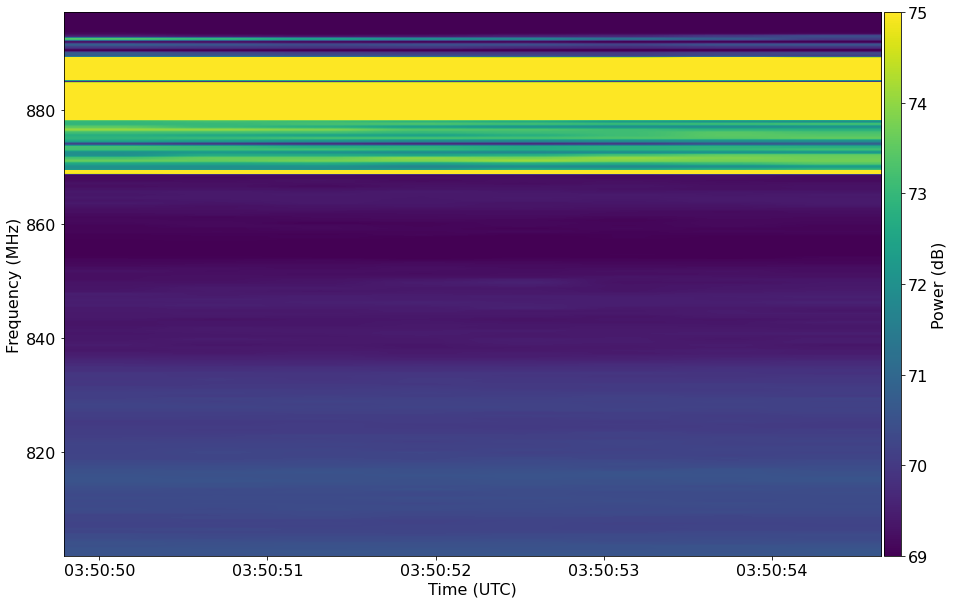

In [ ]:
time_steps = 30
slope_threshold = 10000 #This number needs to be adjusted in order to correctly filter out non-RFI NOTE: 5000 works
LL_Set_RFI_Regions = Find_RFI_Regions(t_plt, LL_set, time_steps, slope_threshold, 850) #Returns an array of [freq, df, time, dt]

first_RFI_region = LL_Set_RFI_Regions[3]

#Try plotting the first RFI_Region

power_min = 69
power_max = 75

t1_plt = first_RFI_region[2] - first_RFI_region[3]
t2_plt = first_RFI_region[2] + first_RFI_region[3]

freq1 = first_RFI_region[0] - first_RFI_region[1]
freq2 = first_RFI_region[0] + first_RFI_region[1]
######################################
rfi_start_idx = find_nearest_idx(t_plt, t1_plt)
rfi_end_idx = find_nearest_idx(t_plt, t2_plt)

f_plt_start_idx = find_nearest_idx(freq, freq1)
f_plt_end_idx = find_nearest_idx(freq, freq2)

RFI_duration_time = t_plt[rfi_start_idx: rfi_end_idx]

RFI_freq_bandwith = freq[f_plt_start_idx: f_plt_end_idx]


fig,axs = plt.subplots(1,1,figsize=(15,10)) 
fs = 16

im = axs.imshow(10.*np.log10(LL_set[rfi_start_idx: rfi_end_idx,f_plt_start_idx: f_plt_end_idx].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
            extent=[RFI_duration_time[0],RFI_duration_time[-1],RFI_freq_bandwith[0],RFI_freq_bandwith[-1]])

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)

axs.set_xlim(RFI_duration_time[0],RFI_duration_time[-1])
# axs.set_ylim(RFI_freq_bandwith[0],RFI_freq_bandwith[-1])
axs.tick_params(axis='both', labelsize=fs)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_xlabel('Time (UTC)',fontsize=fs)        
axs.set_ylabel('Frequency (MHz)',fontsize=fs)

#TODO: I don't think it's clear which region this method is flaggin as RFI


input starting frequency: 900
closest frequency measured: 899.75
possible RFI events: 2
confirmed RFI events: 2


Text(0, 0.5, 'Frequency (MHz)')

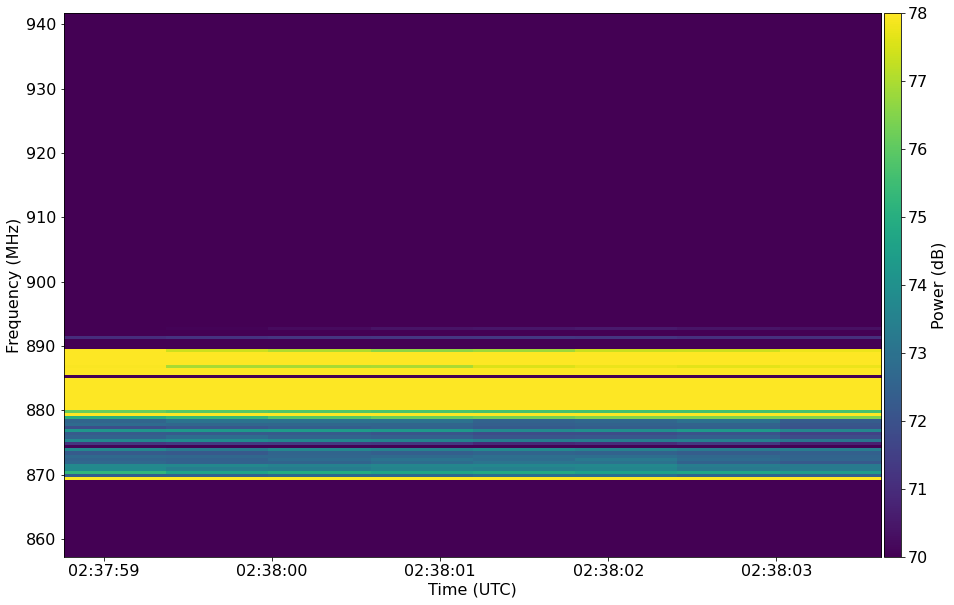

In [ ]:
time_steps = 30
slope_threshold = 10000 #This number needs to be adjusted in order to correctly filter out non-RFI NOTE: 5000 works
LL_Set_RFI_Regions = Find_RFI_Regions(t_plt, LL_set, time_steps, slope_threshold, 900) #Returns an array of [freq, df, time, dt]

first_RFI_region = LL_Set_RFI_Regions[0]

#Try plotting the first RFI_Region

power_min = 70
power_max = 78

t1_plt = first_RFI_region[2] - first_RFI_region[3]
t2_plt = first_RFI_region[2] + first_RFI_region[3]

freq1 = first_RFI_region[0] - first_RFI_region[1]
freq2 = first_RFI_region[0] + first_RFI_region[1]
######################################
rfi_start_idx = find_nearest_idx(t_plt, t1_plt)
rfi_end_idx = find_nearest_idx(t_plt, t2_plt)

f_plt_start_idx = find_nearest_idx(freq, freq1)
f_plt_end_idx = find_nearest_idx(freq, freq2)

RFI_duration_time = t_plt[rfi_start_idx: rfi_end_idx]

RFI_freq_bandwith = freq[f_plt_start_idx: f_plt_end_idx]


fig,axs = plt.subplots(1,1,figsize=(15,10)) 
fs = 16

im = axs.imshow(10.*np.log10(LL_set[rfi_start_idx: rfi_end_idx,f_plt_start_idx: f_plt_end_idx].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
            extent=[RFI_duration_time[0],RFI_duration_time[-1],RFI_freq_bandwith[0],RFI_freq_bandwith[-1]])

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)

axs.set_xlim(RFI_duration_time[0],RFI_duration_time[-1])
# axs.set_ylim(RFI_freq_bandwith[0],RFI_freq_bandwith[-1])
axs.tick_params(axis='both', labelsize=fs)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_xlabel('Time (UTC)',fontsize=fs)        
axs.set_ylabel('Frequency (MHz)',fontsize=fs)

#TODO: I don't think it's clear which region this method is flaggin as RFI
